Machine Learning Nanodegree Capstone Project
Deepa Mohan

Digit Recognition from SVHN Images

In [14]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import scipy.io
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from random import shuffle
from collections import Counter
%matplotlib inline

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename



In [ ]:
train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')

In [4]:
train_matfile = maybe_download('train_32x32.mat')
test_matfile = maybe_download('test_32x32.mat')
extra_matfile = maybe_download('extra_32x32.mat')

Attempting to download: train_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: test_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Attempting to download: extra_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


In [6]:

train_data = scipy.io.loadmat('train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 531131) (531131, 1)


Data Exploration

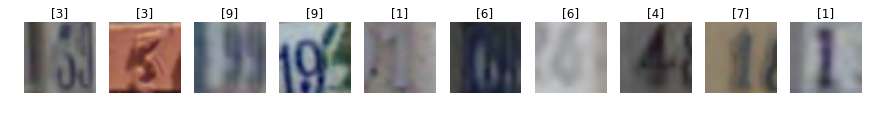

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

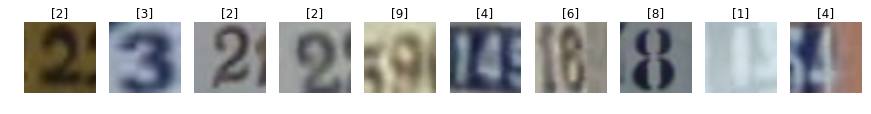

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, extra_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(extra_labels[j], loc='center')
    ax[i].imshow(extra_data[:,:,:,j])

{1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


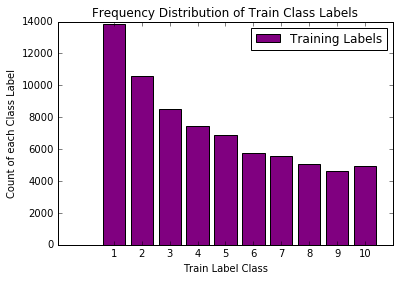

In [26]:
labels = train_labels.reshape(73257).tolist()
labels = dict(Counter(labels))
print(labels)
plt.bar(range(len(labels)), labels.values(), align='center', color = 'purple', label='Training Labels')
plt.xticks(range(len(labels)), labels.keys())
plt.legend()
plt.xlabel('Train Label Class')
plt.ylabel('Count of each Class Label')
plt.title('Frequency Distribution of Train Class Labels')
plt.show()



{1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 6: 1977, 7: 2019, 8: 1660, 9: 1595, 10: 1744}


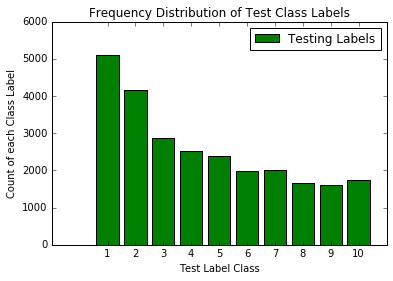

In [25]:
labels = test_labels.reshape(26032).tolist()
labels = dict(Counter(labels))
print(labels)
plt.bar(range(len(labels)), labels.values(), align='center', color = 'green', label='Testing Labels')
plt.xticks(range(len(labels)), labels.keys())
plt.legend()
plt.xlabel('Test Label Class')
plt.ylabel('Count of each Class Label')
plt.title('Frequency Distribution of Test Class Labels')
plt.show()

Creating a validation dataset, shuffling data

In [5]:
batch1_data = []
batch1_labels = []
batch2_data = []
batch2_labels = []

#x = train_data.transpose((2, 0, 1, 3)).reshape((3072, -1))
x=train_data.transpose(3,0,1,2)
print(x.shape)

y = train_labels.reshape(-1,)
print(y.shape)

for i in np.arange(len(y)):
    if y[i] == 10:
        y[i] = 0
index = np.arange(len(y))
shuffle(index)
x = x[index,:,:,:]
y = y[index]

count = np.zeros((10,), 'int32')
for i in np.arange(len(y)):
    if count[y[i]] < 400:
        count[y[i]] += 1
        batch2_data.append(x[i,:,:,:])
        batch2_labels.append(y[i])
    else:
        batch1_data.append(x[i,:,:,:])
        batch1_labels.append(y[i])

print('---train')

x = extra_data.transpose((3, 0, 1, 2))
y = extra_labels.reshape(-1)
del extra_data
del extra_labels

for i in np.arange(len(y)):
    if y[i] == 10:
        y[i] = 0
index = np.arange(len(y))
shuffle(index)
x = x[index,:,:,:]
y = y[index]

count = np.zeros((10,), 'int32')
for i in np.arange(len(y)):
    if count[y[i]] < 200:
        count[y[i]] += 1
        batch2_data.append(x[i,:,:,:])
        batch2_labels.append(y[i])
    else:
        batch1_data.append(x[i,:,:,:])
        batch1_labels.append(y[i])

batch1_data = np.asarray(batch1_data)
batch2_data = np.asarray(batch2_data)
batch1_labels = np.asarray(batch1_labels)
batch2_labels = np.asarray(batch2_labels)

del x, y

print('---extra')

x = test_data.transpose((3, 0, 1, 2))
y = test_labels.reshape(-1,)
for i in np.arange(len(y)):
    if y[i] == 10:
        y[i] = 0
batch3_data = x
batch3_labels = []
for i in np.arange(len(y)):
    batch3_labels.append(y[i])
batch3_data = np.asarray(batch3_data)
batch3_labels = np.asarray(batch3_labels)

print('Check n x f')
print(batch1_data.shape)
print(batch1_labels.shape)
print(batch2_data.shape)
print(batch2_labels.shape)
print(batch3_data.shape)
print(batch3_labels.shape)

(73257, 32, 32, 3)
(73257,)
---train
---extra
Check n x f
(598388, 32, 32, 3)
(598388,)
(6000, 32, 32, 3)
(6000,)
(26032, 32, 32, 3)
(26032,)


Making sure data is still good

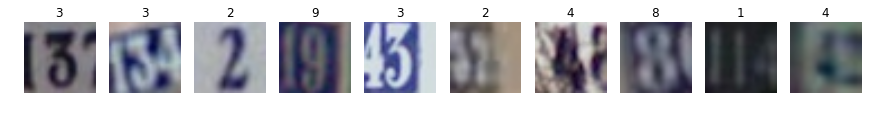

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(batch1_labels[j], loc='center')
    ax[i].imshow(batch1_data[j,:,:,:])

Creating a subset of training, testing data due to compute limitations

In [6]:
def make_arrays(data, label, samples):
    id = np.arange(len(label))
    # perm = np.random.permutation(idx)
    # sample_datas = datas[perm]
    # sample_labels = labels[perm]
    # random_state = np.random.get_state()
    sample_id = np.random.choice(id, size=samples, replace=False)
    sample_data = data[sample_id]
    sample_label = label[sample_id]
    # np.random.set_state(random_state)
    #sample_labels = np.random.choice(labels, size=n_samples, replace=False)
    
    return sample_data, sample_label

train_size, test_size, valid_size = 45000, 15000, 6000

X_train, train_labels = make_arrays(batch1_data,batch1_labels, train_size)
X_test, test_labels = make_arrays(batch3_data,batch3_labels, test_size)
X_valid, valid_labels = make_arrays(batch2_data,batch2_labels, valid_size)

print(X_train.shape)
print(train_labels.shape)
print(X_test.shape)
print(test_labels.shape)
print(X_valid.shape)
print(valid_labels.shape)



(45000, 32, 32, 3)
(45000,)
(15000, 32, 32, 3)
(15000,)
(6000, 32, 32, 3)
(6000,)


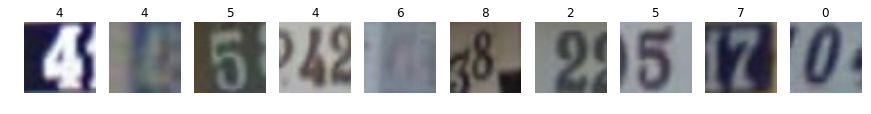

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(X_train[j,:,:,:])

RCG To Grayscale Conversion

In [7]:
image_size = 32  # Pixel width and height.
#pixel_depth = 255.0  # Number of levels per pixel.

def rgb2gray(image):
    image = image.astype(float)
    gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return gray

train_data_gray = rgb2gray(X_train)[:,:,:,0]
test_data_gray = rgb2gray(X_test)[:,:,:,0]
valid_data_gray = rgb2gray(X_valid)[:,:,:,0]

print(train_data_gray.shape)
print(test_data_gray.shape)
print(valid_data_gray.shape)

(45000, 32, 32)
(15000, 32, 32)
(6000, 32, 32)


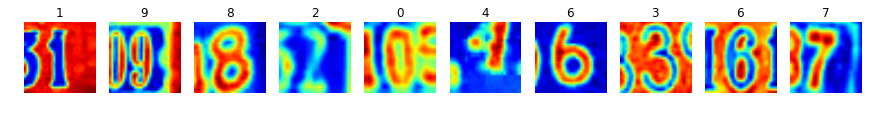

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data_gray[j,:,:])

Normalizing data subtracting mean and diving by STD deviation

In [9]:
def global_contrast_normalize(image, min_divisor=1e-4):
      
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_n = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_n[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_n

train_dataset = global_contrast_normalize(train_data_gray)
test_dataset = global_contrast_normalize(test_data_gray)
valid_dataset = global_contrast_normalize(valid_data_gray)

print(train_dataset.shape, train_data_gray.shape)
print(test_dataset.shape, test_data_gray.shape)
print(valid_dataset.shape, valid_data_gray.shape)



(45000, 32, 32) (45000, 32, 32)
(15000, 32, 32) (15000, 32, 32)
(6000, 32, 32) (6000, 32, 32)


Save the preprocessed file

In [10]:
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 540738437


In [12]:
## loads from pickle file since it has been already created

pickle_file = 'SVHN.pickle'

try:
    files = pickle.load(open(pickle_file,'rb'))
except Exception as e:
    print('Could not find pickle file', pickle_file, ':', e)

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

train_dataset, train_labels = files['train_dataset'],files['train_labels']
print(train_labels.shape)
valid_dataset, valid_labels = files['valid_dataset'], files['valid_labels']
test_dataset, test_labels = files['test_dataset'], files['test_labels']

Compressed pickle size: 540738437
(45000,)


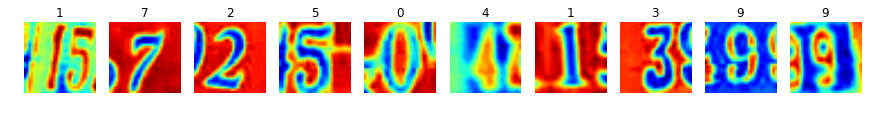

In [18]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_dataset[j,:,:])